# Учебный Проект → «Бета-Банк»

<div class="alert alert-info" role="alert">
    <span style="font-size:0.7rem">Student's note</span>
    <p class="mb-0">В коде использую <code>display()</code> намеренно, потомучто это однозначно даёт понять что планируется вывод / печать результатов. 👌</p>
</div>

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.




In [17]:
import pandas as pd
import sklearn
import re
import matplotlib as mpl
import matplotlib.pyplot as plt


In [18]:
%config InlineBackend.figure_formats = ['svg']

In [19]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,

                'text.color': '#EEEEEE',
                'font.sans-serif': [
                    'Helvetica',
                    'Verdana',
                    'sans-serif'
                    ]
                }

# rcParams.update(custom_params)

In [20]:
random_seed = 108108108

## Загрузите и подготовьте данные.

In [21]:
try:
    customers_data = pd.read_csv('./datasets/churn.csv')
except FileNotFoundError:
    customers_data = pd.read_csv(
        'https://code.s3.yandex.net/datasets/Churn.csv'
    )
    print('FYI data loaded via url')

In [22]:
display(
    customers_data.head(5)
)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [23]:
display(
    len(customers_data['CustomerId'].unique())
)

10000

Удалим столбцы, которые не несут информации..

In [24]:
customers_data.drop(
    columns=['RowNumber',  'Surname'],
    inplace=True
)

Сделаем названия столбцов по+красоте -> `snake_case`

In [25]:
customers_data.columns  = pd.Series(customers_data.columns).apply(
    lambda c: re.sub(r'(?<!^)(?=[A-Z])', '_',  c ).lower()
)

Оставим `customer_id` как индекс.

In [26]:
customers_data.set_index(
    keys='customer_id',
    inplace=True
)

Пробовал в колонке `tenure` заменить `NaN` на медиану. Резудьтат модели не устроил. Медиана всего столбца, кстати, очень близка к мединане в группировке по странам, полу.  
Поэтому удалим все сторки где `tenure` = `NaN`.

In [13]:
display(
    customers_data.loc[customers_data['tenure'].isna()].sample(7)
)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,
15635942,576,France,Male,40,NaN,0.00,2,1,0,112465.19,1
15778089,544,Spain,Male,37,NaN,0.00,2,0,0,135067.02,0
15577970,489,France,Male,34,NaN,0.00,1,0,0,43540.59,0
15689980,725,Spain,Female,36,NaN,118520.26,1,0,0,131173.90,1
15758056,558,France,Male,35,NaN,0.00,2,0,0,111687.57,0
15665790,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0
15710424,435,France,Male,36,NaN,0.00,1,1,1,197015.20,0


In [27]:
customers_data.dropna(axis=0, inplace=True)

In [28]:
display(
    customers_data.info()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 15634602 to 15682355
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   float64
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


None

In [31]:
col_type = {
    'credit_score': 'uint16',
     'geography': 'category',
     'gender': 'category',
     'age': 'uint8',
     'tenure': 'uint8',
     'balance': 'float64',
     'num_of_products': 'uint8',
     'has_cr_card': 'category',
     'is_active_member': 'category',
     'estimated_salary': 'float64',
     'exited': 'category',
}

num_col = [
    'credit_score',
     'age',
     'tenure',
     'balance',
     'num_of_products',
     'estimated_salary',
]
cat_col = [
    'credit_score',
     'geography',
     'gender',
     'age',
     'tenure',
     'balance',
     'num_of_products',
     'has_cr_card',
     'is_active_member',
     'estimated_salary',
     'exited',
]

SyntaxError: expression expected after dictionary key and ':' (1195495207.py, line 2)

In [12]:
display(
    customers_data.describe()
)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


[]

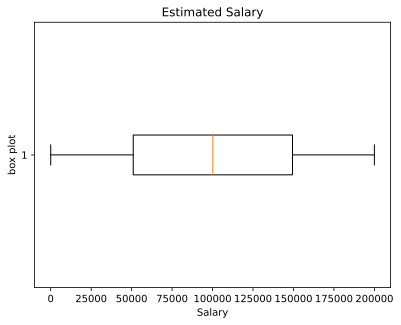

In [34]:
plt.boxplot(
    customers_data['estimated_salary'],
    vert=False
)
plt.title('Estimated Salary')
plt.xlabel('Salary, unt')
plt.ylabel('box plot')
plt.plot()

Поясните порядок действий.

## Исследуйте баланс классов, обучите модель без учёта дисбаланса.

### Кратко опишите выводы.

## Улучшите качество модели, учитывая дисбаланс классов.

### Обучите разные модели и найдите лучшую.

### Кратко опишите выводы.

## Проведите финальное тестирование.

Признаки
`RowNumber` — индекс строки в данных  
`CustomerId` — уникальный идентификатор клиента  
`Surname` — фамилия  
`CreditScore` — кредитный рейтинг  
`Geography` — страна проживания  
`Gender` — пол  
`Age` — возраст  
`Tenure` — сколько лет человек является клиентом банка  
`Balance` — баланс на счёте  
`NumOfProducts` — количество продуктов банка, используемых клиентом  
`HasCrCard` — наличие кредитной карты  
`IsActiveMember` — активность клиента  
`EstimatedSalary` — предполагаемая зарплата  
`Целевой` признак  
`Exited` — факт ухода клиента  

## Как будут проверять мой проект?


На что обращают внимание ревьюер, проверяя проект:
 - Как вы готовите данные к обучению? Все ли типы признаков обрабатываете?
 - Хорошо ли поясняете этапы предобработки?
 - Как исследуете баланс классов?
 - Изучаете ли модель без учёта дисбаланса классов?
 - Какие выводы об исследовании задачи делаете?
 - Корректно ли разбиваете данные на выборки?
 - Как работаете с несбалансированными классами?
 - Правильно ли проводите обучение, валидацию и финальное тестирование модели?
 - Насколько высокое значение F1-меры получаете?
 - Изучаете ли значения метрики AUC-ROC?
 - Следите за структурой проекта и поддерживаете аккуратность кода?